In [1]:
#!pip install numpy uproot

In [2]:
import awkward as ak
import numpy as np
import uproot as uproot
import matplotlib
import matplotlib.pyplot as plt

In [3]:
file = uproot.open('merged.root')


## Test files
#  Single photon events
#file = uproot.open('/eos/cms/store/user/bmaier/hgcal/hue_hackathon/samples_v1/test/singlephoton/singlephoton_merged_test.root')
#  Di-photon events
#file = uproot.open('/eos/cms/store/user/bmaier/hgcal/hue_hackathon/samples_v1/test/diphoton/diphoton_merged_test.root')
#  Single pion events
#file = uproot.open('/eos/cms/store/user/bmaier/hgcal/hue_hackathon/samples_v1/test/singlepion/singlepion_merged_test.root')
#  Multi-particle events
#file = uproot.open('/eos/cms/store/user/bmaier/hgcal/hue_hackathon/samples_v1/test/multiparts/multiparts_merged_test.root')




## Evaluation files
#  Single photon events
#file = uproot.open('/eos/cms/store/user/bmaier/hgcal/hue_hackathon/samples_v1/eval/singlephoton/singlephoton_merged_eval.root')
#  Di-photon events
#file = uproot.open('/eos/cms/store/user/bmaier/hgcal/hue_hackathon/samples_v1/eval/diphoton/diphoton_merged_eval.root')
#  Single pion events
#file = uproot.open('/eos/cms/store/user/bmaier/hgcal/hue_hackathon/samples_v1/eval/singlepion/singlepion_merged_eval.root')
#  Multi-particle events
#file = uproot.open('/eos/cms/store/user/bmaier/hgcal/hue_hackathon/samples_v1/eval/multiparts/multiparts_merged_eval.root')


file.keys()

['lCToTSTsAssoc;1', 'lCToTSTsAssoc/lCTo3simTS_tree;1']

In [4]:
events = file['lCToTSTsAssoc/lCTo3simTS_tree']
events.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
run                  | int32_t                  | AsDtype('>i4')
event                | int32_t                  | AsDtype('>i4')
lumi                 | int32_t                  | AsDtype('>i4')
id                   | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...
pos_x                | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
pos_y                | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
pos_z                | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
energy               | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
time                 | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
time_error           | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
eta                  | std::vector<float>       | AsJagged(AsDtype('>f4'), h

## Input Features

 - `event`: the index of the events in the file
 
Each event contains a varying number of point. For each point:
 - `pos_x`, `pos_y`, `pos_z`: (x,y,z) coordinates of the point
 - `time`: time of the point (not all points have timing information -- a value of -99 indicates no timing information)
 - `eta`, `phi`: [pseudorapidity](https://en.wikipedia.org/wiki/Pseudorapidity), azimuth angle of the point
 - `layer`: layer number of the point
 - `energy`: energy of the point

**[Note]** `simTst_idx` and `enFraction` are the truth labels.

These features are [JaggedArray](https://github.com/scikit-hep/awkward-0.x). This can be thought of as an array of arrays, where the first level of indices correspond to the event indices, and the second level correspond to the LCs within each event.

In [5]:
# To get the total number of events in the file
totEvents = len(events['event'].array())
totEvents

3800

In [6]:
# Using all the events in the file may take too long for quick development. Hence start out with only a few to test things.
nEvents = 20
#nEvents = totEvents

# To get the information of all points from all events in the file
id = events['id'].array(entry_stop=nEvents)
pos_x = events['pos_x'].array(entry_stop=nEvents)
pos_y = events['pos_y'].array(entry_stop=nEvents)
pos_z = events['pos_z'].array(entry_stop=nEvents)
energy = events['energy'].array(entry_stop=nEvents)
eta = events['eta'].array(entry_stop=nEvents)
phi = events['phi'].array(entry_stop=nEvents)
simTst_idx = events['simTst_idx'].array(entry_stop=nEvents)

In [7]:
# To access energy of all points from the first event: this returns a regular numpy array
energy[0]

<Array [0.0447, 0.0599, ... 0.0501, 0.363] type='550 * float32'>

In [8]:
# To get the number of points in each event
nPoints_perEv = ak.num(energy)
nPoints_perEv

<Array [550, 562, 624, 440, ... 195, 734, 529] type='20 * int64'>

In [9]:
# to pad/truncate to a regular 2D array
ak.pad_none(energy, 2, clip=True)

<Array [[0.0447, 0.0599], ... [0.0691, 0.0128]] type='20 * 2 * ?float32'>

In [10]:
# To flatten the jagged array to a 1d array
ak.flatten(energy)

<Array [0.0447, 0.0599, ... 0.113, 0.0604] type='9757 * float32'>

In [11]:
# To get the total number of points within the events
len(ak.flatten(energy))

9757

### Truth definition

The target is to assign each point to up to 3 particle showers - aka Tracksters - sorted by the higher fraction of the point's energy contained. The truth information is as follows:

 - `trueTrackster_idx`: index of the (up to 3) showers associated with the point at hand; if the point is associated to less than 3 showers, the remaining array elements are -1;
 - `enFraction`: the fraction of the point's energy that should be assigned to each of the (up to 3) showers.

In [12]:
trueTrackster_idx = events['simTst_idx'].array(entry_stop=nEvents)
trueTrackster_idx[0]

<Array [[1, -1, -1], [0, ... -1], [0, -1, -1]] type='550 * var * int64'>

In [13]:
enFraction = events['enFraction'].array(entry_stop=nEvents)
enFraction[0]

<Array [[1, -1, -1], [1, ... -1], [1, -1, -1]] type='550 * var * float64'>

In [14]:
events['energy'].array(entry_stop=nEvents)[0]

<Array [0.0447, 0.0599, ... 0.0501, 0.363] type='550 * float32'>

## Dataset Visualisation

In [15]:
font = {'size'   : 16}
matplotlib.rc('font', **font)
def plotXYZ(pos_x, pos_y, pos_z, energy, enFraction, trueTrackster_idx, eventToVisualize, visualizeEnergy):
    '''
        Helper function to plot the points.
        The points belonging to the same shower are colored with the same color.
        The points that are shared among different showers are coloured with only one color (first index)
        pos_x : Points X positions 
        pos_y : Points Y positions 
        pos_z : Points Z positions 
        energy: Points Energies 
        enFraction: Points Energy Fractions 
        trueTrackster_idx: True Trackster to which the point is associated to
        eventToVisualize: Event you want to visualize, integer.
        visualizeEnergy: Marker size proportional to point energy, bool
    '''
    fractionEnergy = []
    #compute the energy contribution of each points in each cluster (Trackster) to which it is associated
    for i in range(len(enFraction[eventToVisualize])):
        tmp = []
        for j in range(len(enFraction[eventToVisualize][i])): 
            if(enFraction[eventToVisualize][i][j] != -1):
                # Energy * fraction
                tmp.append(enFraction[eventToVisualize][i][j] * energy[eventToVisualize][i])
            else:
                tmp.append(0)
        fractionEnergy.append(tmp)   
    fig = plt.figure(figsize = (13,13))
    ax = fig.add_subplot(2,2,1,projection='3d')
    xs = ak.to_numpy(pos_x[eventToVisualize])
    ys = ak.to_numpy(pos_y[eventToVisualize])
    zs = ak.to_numpy(pos_z[eventToVisualize])
    trueTrackster_idxAk = ak.Array(trueTrackster_idx) #transform to awkward array
    trueTrackster_idxs = ak.to_numpy(trueTrackster_idxAk[eventToVisualize])
    if(visualizeEnergy == True):
        sizes = [s[0]*5 for s in fractionEnergy] #marker size proportional to point energy
    else:
        sizes = 5
    ax.scatter(xs, zs, ys, s = sizes, marker = 'o', c = trueTrackster_idxs[:,0], alpha = .5)
    ax.set_xlabel('$X$', rotation=150)
    ax.set_ylabel('$Z$')
    ax.set_zlabel('$Y$',rotation=60)
    ax.set_title("XYZ")
    fig.suptitle(f"Event {eventToVisualize}", fontsize = 16)
    ax = fig.add_subplot(2,2,2)
    ax.scatter(xs, ys,s = sizes, c = trueTrackster_idxs[:,0], alpha = .5)
    ax.set_xlabel('$X$')
    ax.set_ylabel('$Y$')
    ax.set_title("X-Y")
    ax = fig.add_subplot(2,2,3)
    ax.scatter(xs, zs,s = sizes, c = trueTrackster_idxs[:,0], alpha = .5)
    ax.set_xlabel('$X$')
    ax.set_ylabel('$Z$')
    ax.set_title("X-Z")
    ax = fig.add_subplot(2,2,4)
    ax.scatter(ys, zs,s = sizes, c = trueTrackster_idxs[:,0], alpha = .5)
    ax.set_xlabel('$Y$')
    ax.set_ylabel('$Z$')
    ax.set_title("Y-Z")
    plt.show()    

def plotEtaPhi(eta, phi, energy, enFraction, trueTrackster_idx, eventToVisualize, visualizeEnergy):
    '''
        Helper function to plot the points in the (\eta,\phi) plane.
        The points belonging to the same shower are colored with the same color.
        The points that are shared among different showers are coloured with only one color (first index)
        eta : Points \eta 
        phi : Points \phi positions 
        energy: Points Energies 
        enFraction: Points Energy Fractions 
        trueTrackster_idx: True Trackster to which the point is associated to
        eventToVisualize: Event you want to visualize, integer.
        visualizeEnergy: Marker size proportional to point energy, bool
    '''

    #compute the energy contribution of each points in each cluster (Trackster) to which it is associated
    fractionEnergy = []
    for i in range(len(enFraction[eventToVisualize])):
        tmp = []
        for j in range(len(enFraction[eventToVisualize][i])): 
            if(enFraction[eventToVisualize][i][j] != -1):
                # Energy * fraction
                tmp.append(enFraction[eventToVisualize][i][j] * energy[eventToVisualize][i])
            else:
                tmp.append(0)
        fractionEnergy.append(tmp)   
    fig = plt.figure(figsize = (7,7))
    if(visualizeEnergy == True):
        sizes = [s[0]*5 for s in fractionEnergy] #marker size proportional to point energy
    else:
        sizes = 5
    trueTrackster_idxAk = ak.Array(trueTrackster_idx) #transform to awkward array
    trueTrackster_idxs = ak.to_numpy(trueTrackster_idxAk[eventToVisualize])
    plt.scatter(eta[eventToVisualize], phi[eventToVisualize], s = sizes,  c = trueTrackster_idxs[:,0], alpha = .5 ) 
    plt.xlabel("$\eta$")
    plt.ylabel("$\phi$")
    plt.title(f"Event {eventToVisualize} - ($\eta$,$\phi$)")
    plt.show()

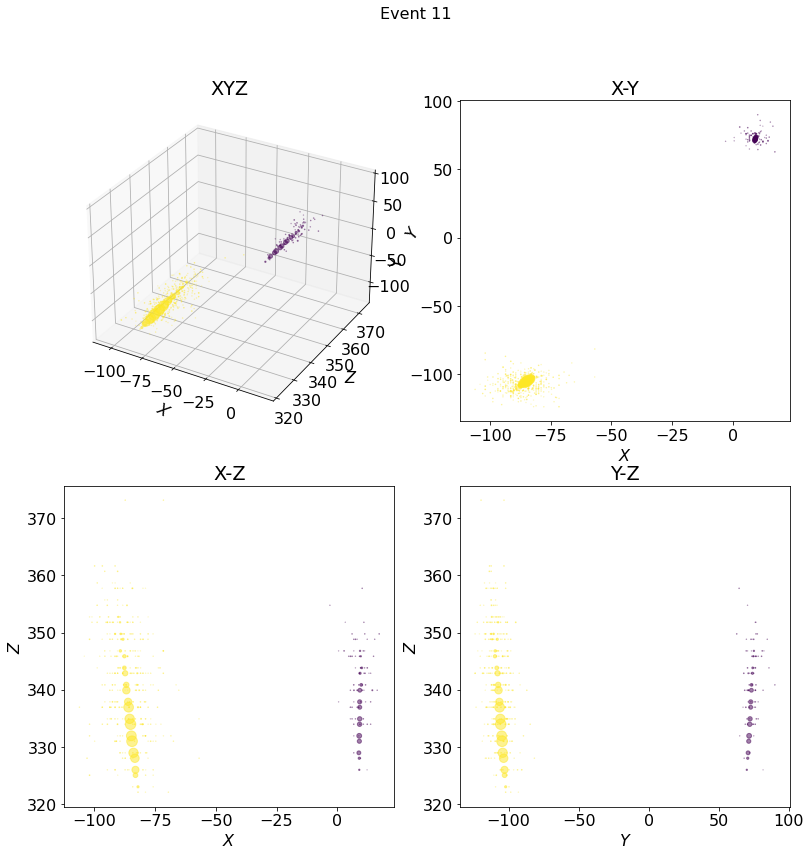

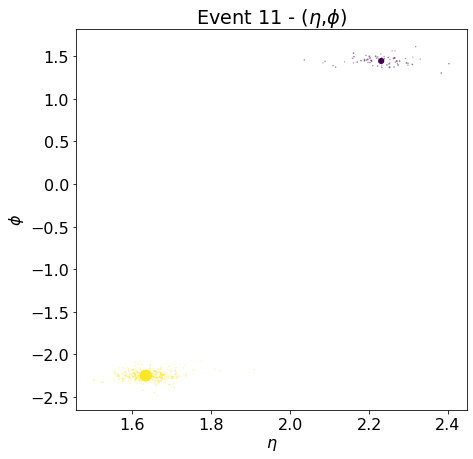

In [16]:
eventToVisualize = 11

plotXYZ(pos_x, pos_y, pos_z, energy, enFraction, trueTrackster_idx, eventToVisualize, True)
plotEtaPhi(eta, phi, energy, enFraction, trueTrackster_idx, eventToVisualize, True)

## Pattern Recognition

An example of pattern recognition is provided. 
In first approximation it looks like points belonging to the same particle have very similar eta and phi coordinates. 
Maybe we can just create a big 2D tiling structure, and cluster together all those points that lie in the same tile?

In [17]:
points = list()

for evt in range(nEvents):
    points.append(np.array(list(zip(id[evt],pos_x[evt],pos_y[evt],pos_z[evt],eta[evt],phi[evt],energy[evt]))))  

In [18]:
from math import pi

# points never exceed 3.2 in eta
maxEta = 3.2
# points are never smaller than 1.5 in eta
minEta = 1.5
etaRange = maxEta - minEta
nEtaBins = 20
nPhiBins = 64
# let's linearize the 2-D tiling
nBins = nEtaBins * nPhiBins

etaBinSize = etaRange/nEtaBins
# phi goes from -pi to pi, so phiRange would be 2*pi
phiBinSize = 2*pi/nPhiBins

In [19]:
def clamp(num, min_value, max_value):
    """Clamps num between two boundaries, min_value and max_value."""
    return int(max(min(num, max_value), min_value))

def etaBin(eta):
    bin = (eta - minEta) / etaBinSize
    return clamp(bin,0,nEtaBins-1)
    

def phiBin (phi) : 
    bin =  (phi + pi) / phiBinSize
    return clamp(bin,0,nPhiBins-1)


def globalBin(eta, phi):
    return phiBin(phi) + etaBin(eta) * nPhiBins

output_idx  = list()
output_enFr = list()
allTracksters = list()
for evt in range(nEvents):
    # the histogram contains a list of point ids per bin
    histogram = list()
    for i in range(nBins):
        histogram.append(list())
    tracksters = list()
    for p in points[evt] :
        # given eta and phi of a point, find the bin in the histogram 
        binId = globalBin(p[4],p[5])
        bin = histogram[binId]
        # append the id of the point to the list of the bin
        bin.append(int(p[0]))
    # now that we have filled the histogram,
    # check the bins that contain at least 5 points
    # and create a trackster with those ids
    for bin in histogram :
        tmpTrackster = []
        for point_id in bin:
            tmpTrackster.append(point_id)
        if len(tmpTrackster)>0:
            tracksters.append(tmpTrackster)
    
    # create output lists 
    # for every point we want as a result the three top tracksters it contributed to
    output_idx_tmp = [[-1, -1, -1] for point in range(len(points[evt]))]
    # and the fraction of the energy that was contributed to it
    output_enFr_tmp = [[0.0, 0.0, 0.0] for point in range(len(points[evt]))]

    for tracksterId in range(len(tracksters)):
#         print("trackster: ", tracksterId, " contains ", tracksters[tracksterId])

        # I found at most only one trackster per point, which will get fraction 1.0
        for lcId in tracksters[tracksterId]:
            output_idx_tmp[lcId][0] = tracksterId
            output_enFr_tmp[lcId][0] = 1.0
#     for lcId in output_idx_tmp:
#         print("layercluster ", lcId, " associated to trackster : " , lcId[0])
    # Adding my results to my global output for validation
    output_idx.append(output_idx_tmp)
    output_enFr.append(output_enFr_tmp)
    allTracksters.append(tracksters)
    #print(allTracksters)

In [20]:
# print (output_idx[0])

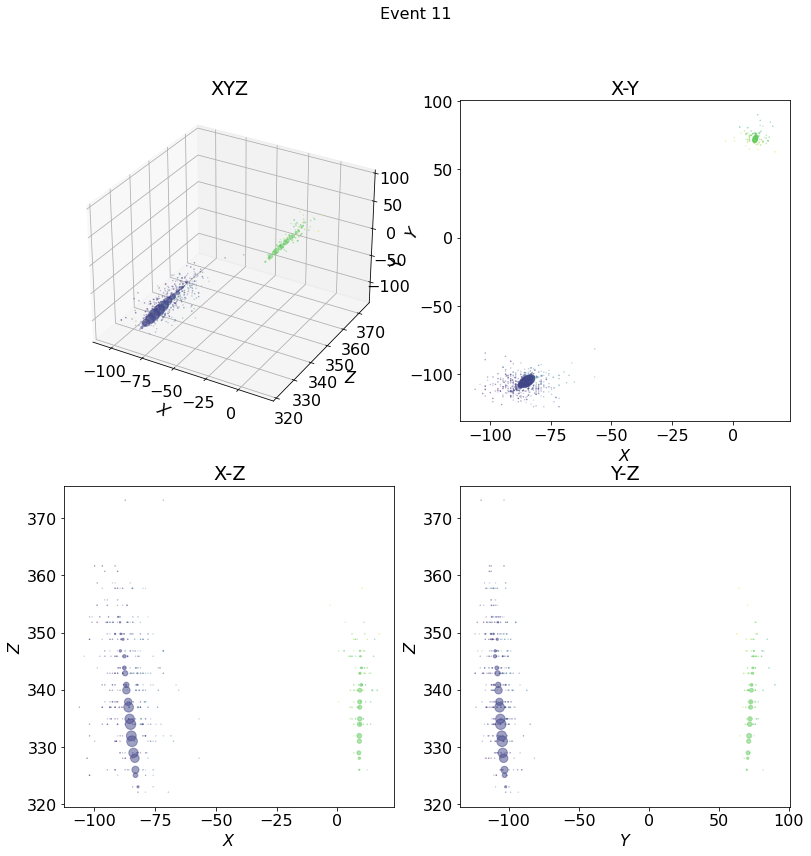

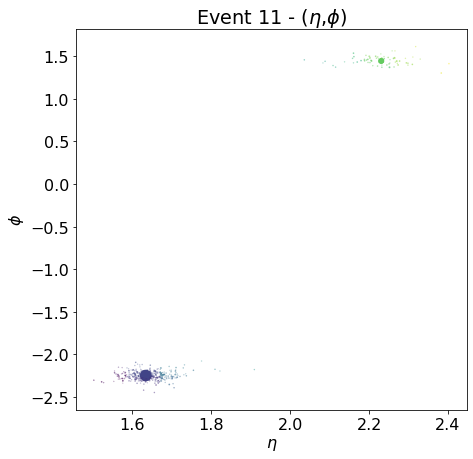

In [21]:
#Visualize the results obtained ....
eventToVisualize = 11
plotXYZ(pos_x, pos_y, pos_z, energy, output_enFr, output_idx, eventToVisualize, True)
plotEtaPhi(eta, phi, energy, output_enFr, output_idx, eventToVisualize, True)

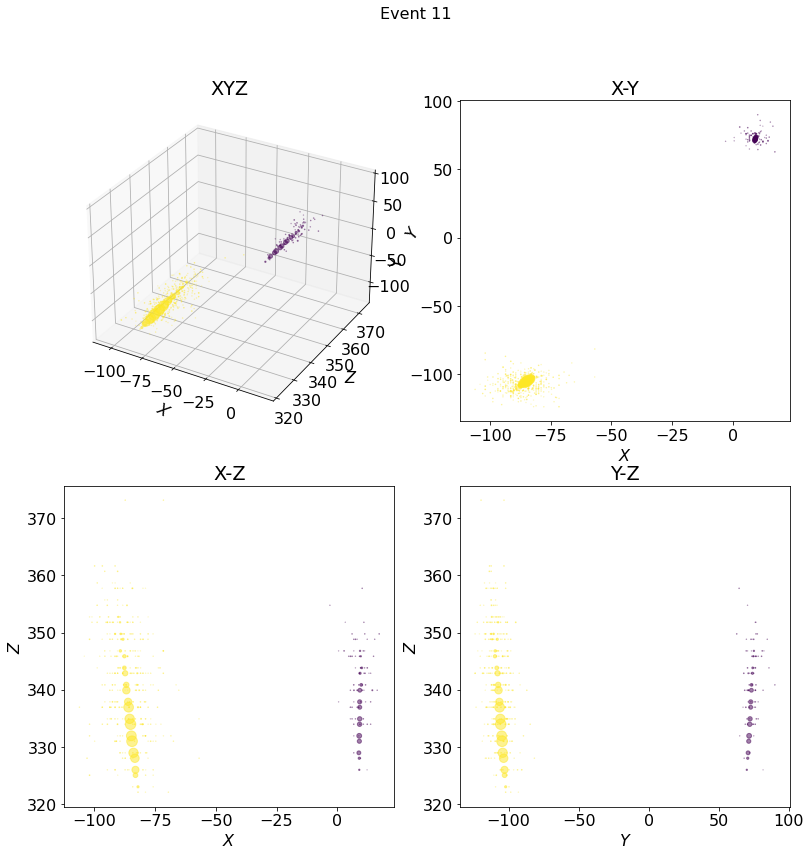

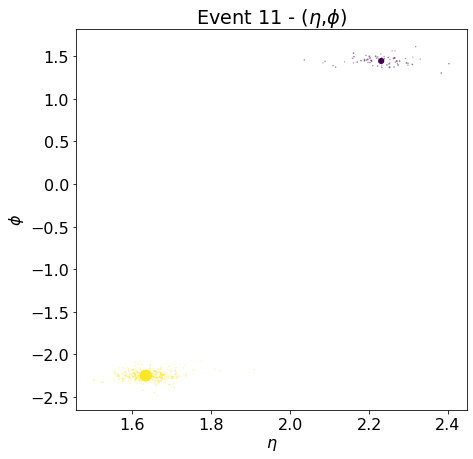

In [22]:
#... and compare with the truth
eventToVisualize = 11
plotXYZ(pos_x, pos_y, pos_z, energy, enFraction, trueTrackster_idx, eventToVisualize, True)
plotEtaPhi(eta, phi, energy, enFraction, trueTrackster_idx, eventToVisualize, True)